In [1]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


mbtrack2 version 0.6.0.48
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Mar. 25, 2024. doi: 10.5281/zenodo.10871040.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




In [2]:
ring2 = v2366(IDs='close', load_lattice=False)
chro = [1.6, 1.6]
ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
Q_S = ring.synchrotron_tune(1.8e6)

In [16]:
n_macroparticles = 1e6
n_turns = 1e5#5.0e4
# n_turns_wake = 50
Qp_x = 1.6
Qp_y = 1.6
id_state = 'close'
include_Zlong = 'True'
harmonic_cavity = 'False'
bunch_current = 5.2e-3
max_kick = 0.0e-6
sc = 'True'
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/sbi/'
filename = (folder+
            f'monitors(n_mp={n_macroparticles:.1e},'+
            f'n_turns={n_turns:.1e},'+
            f'n_bin=100,bunch_current={bunch_current:.1e},'+
            f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},id_state={id_state:},'+
            f'Zlong={include_Zlong:},'+
            f'cavity={harmonic_cavity:},'+
            f'max_kick={max_kick:.1e},'+
            f'sc={sc:}'+
            ').hdf5')
f = hp.File(filename
           )
print(f.keys())
y = f['BunchData_0']['mean'][2, :]
yp = f['BunchData_0']['mean'][3, :]
sig_z = f['BunchData_0']['std'][4, :]
Jy = f['BunchData_0']['cs_invariant'][1, :]
y = np.trim_zeros(y)
yp = np.trim_zeros(yp)

sig_y = f['BunchData_0']['std'][2, 0]
turns = np.linspace(0, n_turns, y.shape[0])
fig, ax = plt.subplots(1, 1)

risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=Qp_x,
            Qp_y=Qp_y,
            n_bunches=1,
            n_sampling = 1)
dQcoh = 1/(2*np.pi*risetime)
print(f'Coherent tune shift is {(dQcoh/Q_S):.1e}')
ring = v2366_v2(IDs=id_state)
dQrad = 1/(ring.tau[1]*ring.omega0)
print(f'Threshold current is {500/dQcoh*dQrad:.1f} mA')
print(f'Synchrotron period in turns {1/(2*np.pi*ring.synchrotron_tune(1.8e6)):.1f}')
ax.set_xlim(0, 2e4)
ax.set_ylim(-1e4, 1e4)
# plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/offset(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')
f.close()
with hp.File(filename) as f:
    print(f.keys())
    print(f['BunchData_0'].keys())
    print(f['WakePotentialData_0'].keys())
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    t = f['WakePotentialData_0']['time'][:]
    
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]
    Wdip = f['WakePotentialData_0']['Wydip'][:]    
    time = f['WakePotentialData_0']['time'][:]

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
Coherent tune shift is -4.0e-04
Threshold current is -11648.2 mA
Synchrotron period in turns 76.9
<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


[-1.12721475e-09 -4.23972361e-09  2.26145012e-09 ...  2.58139685e-08
  1.45969828e-08 -3.64415559e-08]


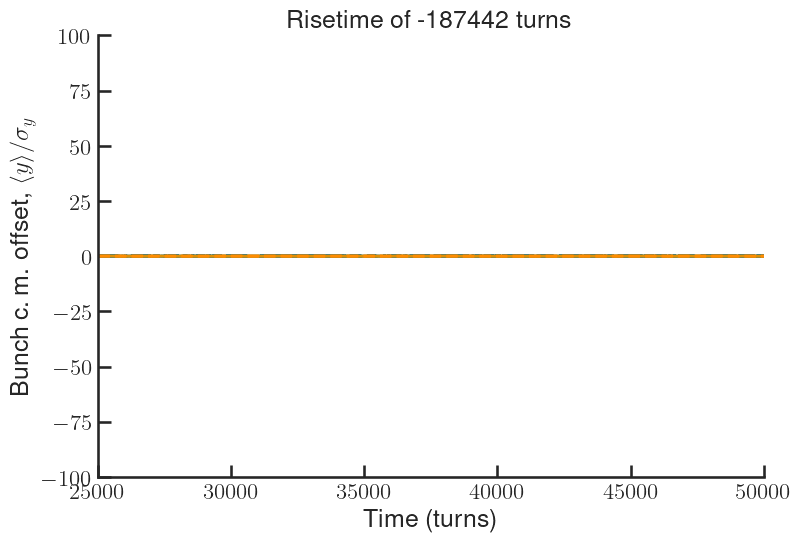

In [17]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
print(m[2,:])
y = np.trim_zeros(m[2,:], trim='b')
yp = np.trim_zeros(m[3,:], trim='b')

yp = yp[np.abs(y) < 1e10]
y = y[np.abs(y) < 1e10]

# y = y[~np.isnan(y)]
# yp = yp[~np.isnan(yp)]

ax.plot(y/std[2, 0])
min_level = 0.1
signal = np.sqrt(y**2+(BETA_Y_SMOOTH*yp)**2)/std[2,0]
smoothing_window_size = 10
risetime = fit_risetime(signal,
                      min_level=min_level, 
                      smoothing_window_size=smoothing_window_size,
                      matplotlib_axis=ax)
ax.set_xlabel('Time (turns)')
ax.set_ylabel('Bunch c.\,m. offset, $\langle y \\rangle/\sigma_y$')
ax.set_xlim(25000, 50000)
ax.set_ylim(-100, 100)
ax.title.set_text(f'Risetime of {risetime:.0f} turns')#, $N_m={:.1e}$'.format(risetime, n_macroparticles))
# plt.savefig(FOLDER_FIG+'beam_offset(Qp_y={:}).pdf'.format(Qp_y))

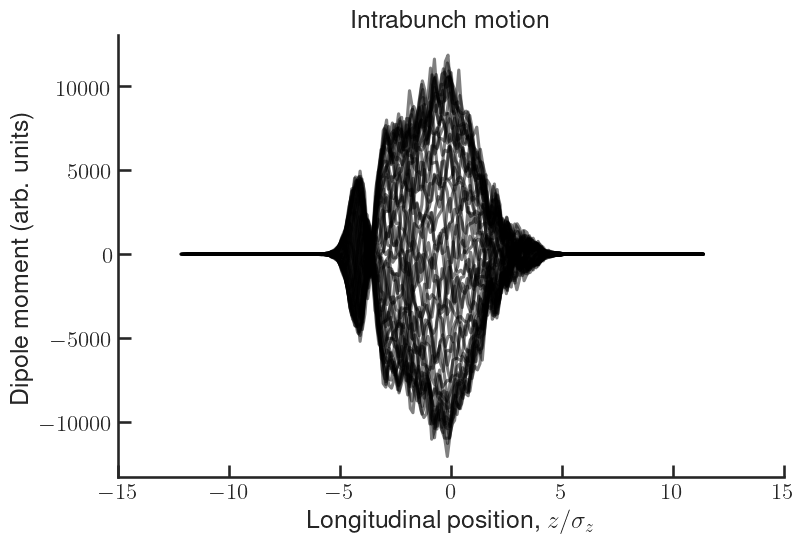

In [48]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 0
lineend =50
# ax.plot((tau_y[:,-linenumber:])*c/SIGMA_Z, profile_y[:,-linenumber:], color='black', alpha=0.5)
ax.plot(tau[:,linestart:lineend]*c/SIGMA_Z, dip[:,linestart:lineend]*p[:,linestart:lineend], color='black', alpha=0.5)
ax.set_xlim(-15, 15)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
# ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
ax.title.set_text('Intrabunch motion')

plt.savefig(FOLDER_FIG+'intrabunch_motion(Qp_y={:}).pdf'.format(Qp_y))

0.002
Coherent synchrotron tune is 0.0009000000000000001
8.814571766148724


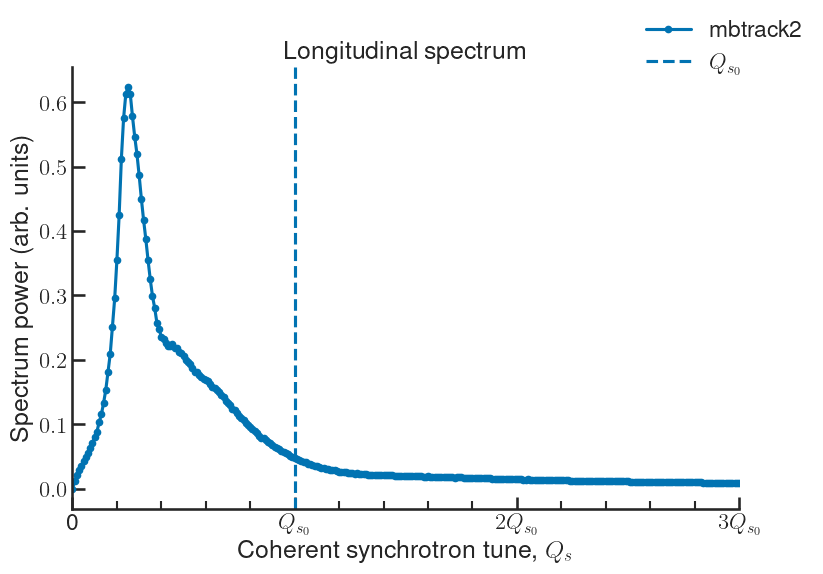

In [6]:
%matplotlib inline
from scipy.signal import find_peaks
from matplotlib.ticker import AutoMinorLocator


fftz = np.abs(np.fft.rfft(m[5,]-np.mean(m[5,])))
fftfreqz = np.fft.rfftfreq(m[5,].shape[0])
Q_S = 2.0e-3
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqz, fftz, marker='.', label='mbtrack2')
ax.axvline(Q_S, linestyle='dashed', label='$Q_{s_0}$')
print(Q_S)
ax.set_ylabel('Spectrum power (arb. units)')
ax.set_xlabel('Coherent synchrotron tune, $Q_s$')
ax.title.set_text('Longitudinal spectrum')
find_peaks(fftz)[0].shape
Q_coh = fftfreqz[find_peaks(fftz)[0][1]]
# ax.axvline(Q_coh, linestyle='dashed', color='r', label='$\Delta Q_{s_\mathrm{coh}}$')
print('Coherent synchrotron tune is {:}'.format(Q_coh))

ax.set_xticks([0, Q_S, 2*Q_S, 3*Q_S])
ax.set_xticklabels(['0', '$Q_{s_0}$', '$2Q_{s_0}$', '$3Q_{s_0}$'])
ax.set_xlim(0, 3*Q_S)
# ax.set_ylim(0, 5e-8)
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
# plt.savefig(FOLDER_FIG+'synchrotron_tune(Qp_y={:}).pdf'.format(int(Qp_y)))
plt.figlegend()
# plt.savefig('/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/Q_s.svg')
print(std[4,0]/1e-12)

### Chromaticity vs growth rate

In [7]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 1.0e5 
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 1.6
Qp_y = np.linspace(0.1, 5.0, 50)
max_kick = 0#1.8e-6
ID_state = 'close'
Zlong='False'
cavity='False'
# tmci_current = 1e-3*np.linspace(0.1, 5, 50)
tmci_current  = 1e-3*np.linspace(0.2, 7, 35)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []
ring2 = v2366(IDs=ID_state, load_lattice=False)

ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
for Qp in tqdm(Qp_y):
    try:
        risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                n_turns, 
                n_bin,
                bunch_current, 
                Qp,
                Qp,
                ID_state,
                Zlong,
                cavity,
                max_kick)
    except:
        risetime = peak_freqs = peak_amps = final_energy_offset = max_energy_offset = min_energy_offset = final_bunch_length = np.nan
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
risetimes = np.array(risetimes)
indices = np.isnan(risetimes)
print(risetimes[indices])
risetimes[np.isnan(risetimes)] = np.inf
# risetimes_FB = risetimes

[nan nan nan nan nan nan nan nan nan]


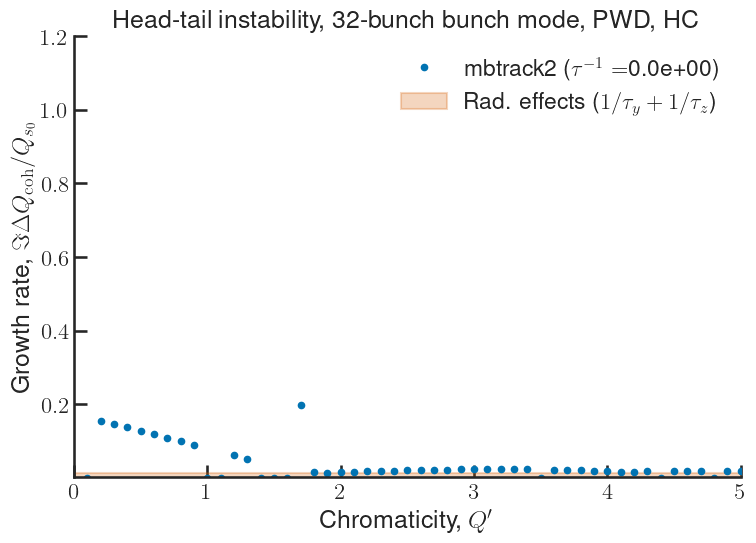

In [10]:
Q_s0 = 2.0e-3
plt.plot(Qp_y, 1/(2*np.pi*risetimes*Q_s0), lw=0, marker='.', label="mbtrack2 ($\\tau^{-1} = $"+f"{0:.1e})")
# plt.plot(Qp_y, 1/(2*np.pi*risetimes_FB*Q_s0), lw=0, marker='.', label="mbtrack2 ($\\tau^{-1} = $"+f"{1/50:.1e})")

ximp = 1.0
# for damper_gain in [0]:
#     df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z=2.7e-11,ID=close,plane=vertical,Qp=0.0,M=1,Q_s=1.1e-03,n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
#     df['BunchLength'].unique()/4
#     df = df.drop_duplicates(['BunchCurrent'], keep='first')
#     plt.plot(df['BunchCurrent']/1e-3, -df['eigvals_im']/Q_s0, lw=1, marker='.', label=f'g={damper_gain:.3f} (1/turns)')
Q_s = 2.1e-3#0.95e-3
sigma_z = 9e-12#22e-12
# for damper_gain in [2e-2]:
#     filename = f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sigma_z:.1e},id=close,plane=vertical,Ib={bunch_current:.1e},M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},impedance_multiplier=1.0).csv'
#     df = pd.read_csv(filename,
#                      sep='\t')
#     Q_s0 = 2.1e-3
#     df = df.drop_duplicates(['chromaticity'])
#     plt.plot(df['chromaticity'], -df['eigvals_im']/Q_s0, marker='.', lw=2, label="DELPHI ($\\tau^{-1} = $"+f"{damper_gain:.1e})")

plt.fill_between(np.linspace(0, 5, 50), 0, 1/(2*np.pi*ring.tau[1]*ring.f0*Q_s0)+1/(2*np.pi*ring.tau[2]*ring.f0*Q_s0), color='r', label='Rad. effects ($1/\\tau_y+1/\\tau_z$)', alpha=0.25)

# print(f'Radiation damping rate should be {1/(2*np.pi*ring.tau[1]*ring.f0):.1e}')
# print(f'Radiation damping time should be {ring.tau[1]*ring.f0:.1e}')

plt.xlabel("Chromaticity, $Q'$")
plt.ylabel('Growth rate, $\Im\Delta Q_\mathrm{coh}/Q_{s_0}$')
# plt.ylabel('Growth rate, $\\tau^{-1}$ (1/turns)')

plt.title('Head-tail instability, 32-bunch bunch mode, PWD, HC')
plt.xlim(0, 5)
plt.ylim(1e-3, 1.2)
plt.legend(loc='upper right')
# plt.savefig('../../data/processed/ht_chroma_32@200mA_pwd.png')
# plt.savefig('../../data/processed/ht_chroma_32@200mA_pwd.pdf')

### Feedback

449.215398432597
599.6859537244113
359.4765365282628
nan


Text(0.5, 0, 'Time, $t$ (turns)')

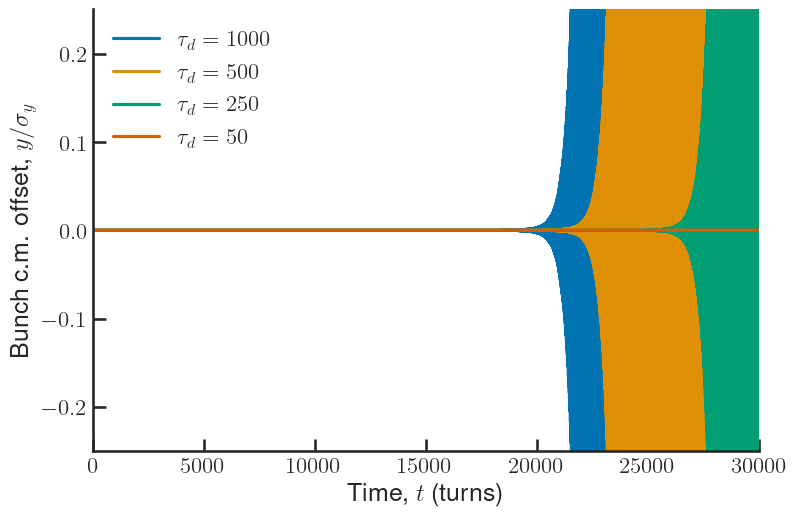

In [3]:
# f.keys()
from postprocessing import *
labels = [f'$\\tau_d = {1000}$', f'$\\tau_d = {500}$', f'$\\tau_d = {250}$', f'$\\tau_d = {50}$']
for i, max_kick in enumerate([3.2e-06, 1.6e-06, 0.8e-06, 0.8e-7]):
    f = hp.File(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/fbt/monitors(n_mp=1.0e+05,n_turns=5.0e+04,n_bin=100,bunch_current=6.3e-03,Qp_x=1.60,Qp_y=1.60,id_state=close,Zlong=True,cavity=False,max_kick={max_kick:.1e}).hdf5')
    y = f['BunchData_0']['mean'][2,:]
    yp = f['BunchData_0']['mean'][3,:]
    sig_y = f['BunchData_0']['std'][2,0]
    Jy = f['BunchData_0']['cs_invariant'][2,:]
    fig, ax = plt.subplots(1, 1)
    n_macroparticles = 1e5
    n_turns = 5e4
    bunch_current = 6.25e-3
    risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=1.6,
            Qp_y=1.6,
            n_bunches=1,
            n_sampling = 1)
    print(risetime)
    f.close()
    plt.plot(y, label=labels[i])
    plt.title('')
plt.legend(loc='upper left')
plt.xlim(0, 30_000)
plt.ylim(-.25, .25)
plt.ylabel('Bunch c.m. offset, $y/\sigma_y$')
plt.xlabel('Time, $t$ (turns)')


### Thresholds at fixed chromaticity

In [27]:
%matplotlib inline
n_macroparticles = 1e6
n_turns = 5e4
n_bin = 100
bunch_current = 6.0e-3
Qp_x = 1.6
Qp_y = 1.6

ID_state = 'close'
Zlong='True'
cavity='False'
tmci_current = 1e-3*np.linspace(0.2, 7, 35)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []

for bunch_current in tqdm(tmci_current):
    try:
        risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                    n_turns, 
                    n_bin,
                    bunch_current, 
                    Qp_x,
                    Qp_y,
                    ID_state,
                    Zlong,
                    cavity,
                    sc='False')
    except:
        risetime = peak_freqs = peak_amps = final_energy_offset = max_energy_offset = min_energy_offset = final_bunch_length = np.nan
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)

  0%|          | 0/35 [00:00<?, ?it/s]

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  while exponent < min_n_risetimes / t[until-1]:
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  while exponent < min_n_risetimes / t[until-1]:
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  while exponent < min_n_risetimes / t[until-1]:


In [28]:
%matplotlib inline
risetimes = np.array(risetimes)
indices = np.isnan(risetimes)
print(risetimes[indices])
risetimes[np.isnan(risetimes)] = np.inf
risetimes_ht_no_sc = risetimes
# risetimes_ht_sc = risetimes

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


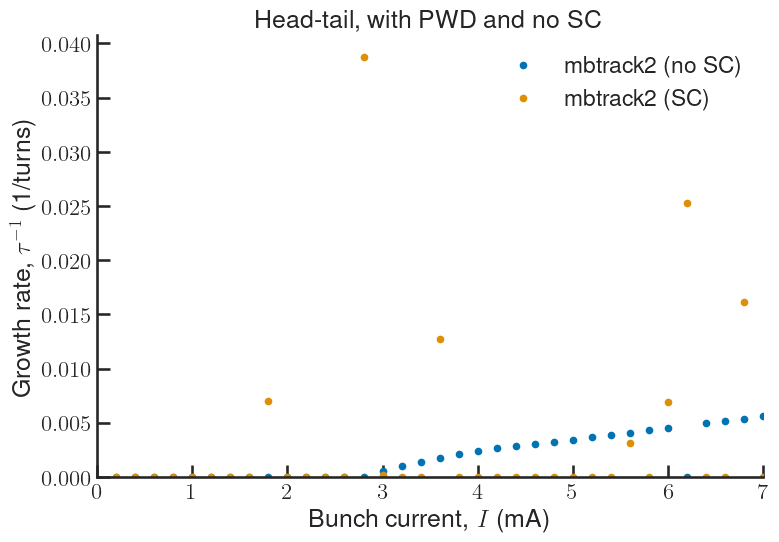

In [29]:
Q_s0 = 2.1e-3
sbs.color_palette('colorblind')
plt.plot(tmci_current*1e3, 1/(risetimes_ht_no_sc), lw=0, marker='.', label='mbtrack2 (no SC)')
plt.plot(tmci_current*1e3, 1/(risetimes_ht_sc), lw=0, marker='.', label='mbtrack2 (SC)')

ximp = 1.0
# for damper_gain in [0]:
#     df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z=2.7e-11,ID=close,plane=vertical,Qp=0.0,M=1,Q_s=1.1e-03,n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
#     df['BunchLength'].unique()/4
#     df = df.drop_duplicates(['BunchCurrent'], keep='first')
#     plt.plot(df['BunchCurrent']/1e-3, -df['eigvals_im']*2*np.pi, lw=1, marker='.',
#              # label=f'g={damper_gain:.3f} (1/turns)',
#              label=f'DELPHI (no SC)',
#              # color='r'
#             )
plt.xlim(0, 7)
plt.ylim(0, )
plt.xlabel('Bunch current, $I$ (mA)')
# plt.ylabel('Growth rate, $\Im\Delta Q_\mathrm{coh}/Q_{s_0}$')
plt.ylabel('Growth rate, $\\tau^{-1}$ (1/turns)')

plt.title('Head-tail, with PWD and  no SC')
plt.legend()
plt.savefig('../../data/processed/hti_with_pwd_with_SC.png')

In [75]:
from machine_data import v2366_v3
r = v2366_v3(IDs='open', V_RF = 1.7e6)

In [64]:
np.nanmean(sigmas_z)*1e12

21.89622191217351

In [6]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 5.0e4 
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 1.6
Qp_y = 1.6 #np.linspace(0.1, 5.0, 50)
Qp = 1.6
max_kick = 0
ID_state = 'close'
Zlong='True'
cavity='False'
# tmci_current = 1e-3*np.linspace(0.1, 5, 50)
tmci_current  = 1e-3*np.linspace(0.2, 7, 35)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []
ring2 = v2366(IDs=ID_state, load_lattice=False)

ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
for bunch_current in tqdm(tmci_current):
    try:
        risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                n_turns, 
                n_bin,
                bunch_current, 
                Qp,
                Qp,
                ID_state,
                Zlong,
                cavity,
                max_kick, 
                sc='False')
    except:
        risetime = peak_freqs = peak_amps = final_energy_offset = max_energy_offset = min_energy_offset = final_bunch_length = np.nan
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)

  0%|          | 0/35 [00:00<?, ?it/s]

In [7]:
risetimes = np.array(risetimes)
indices = np.isnan(risetimes)
print(risetimes[indices])
risetimes[np.isnan(risetimes)] = np.inf
# risetimes_FB = risetimes

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]


0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
26464    0.079439
26465    0.098973
26466    0.184162
26467    0.193524
26468    1.391479
Name: eigvals_im, Length: 26469, dtype: float64
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
35056    0.128117
35057    0.171050
35058    0.196980
35059    0.208635
35060    2.373905
Name: eigvals_im, Length: 35061, dtype: float64


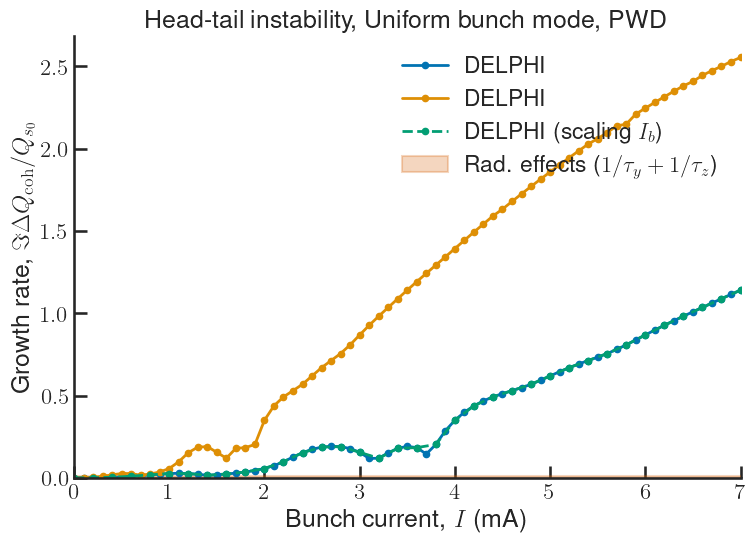

In [13]:
Q_s0 = 2.0e-3
# print(risetimes)
# plt.plot(tmci_current*1e3, 1/(2*np.pi*risetimes*Q_s0), lw=0, marker='.', label="mbtrack2")# ($\\tau^{-1} = $"+f"{0:.1e})")
# plt.plot(Qp_y, 1/(2*np.pi*risetimes_FB*Q_s0), lw=0, marker='.', label="mbtrack2 ($\\tau^{-1} = $"+f"{1/50:.1e})")

ximp = 1.0
# for damper_gain in [0]:
#     df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z=2.7e-11,ID=close,plane=vertical,Qp=0.0,M=1,Q_s=1.1e-03,n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
#     df['BunchLength'].unique()/4
#     df = df.drop_duplicates(['BunchCurrent'], keep='first')
#     plt.plot(df['BunchCurrent']/1e-3, -df['eigvals_im']/Q_s0, lw=1, marker='.', label=f'g={damper_gain:.3f} (1/turns)')
Q_s =2.1e-3 #.27e-3 #0.95e-3 #2.1e-3 
sigma_z = 9e-12 #63e-12 #23e-12#9.0e-12# 
# for damper_gain in [0]:
damper_gain = 0
for ximp in [1, 2]:
    # filename = f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sigma_z:.1e},id=close,plane=vertical,Ib=1.2e-03,M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},impedance_multiplier=1.0).csv'
    filename = f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sigma_z:.1e},ID=close,plane=vertical,Qp=1.6,M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv'
    
    df = pd.read_csv(filename,
                     sep='\t')
    print(df['eigvals_im']/Q_s0)
    Q_s0 = 2.1e-3
    df = df.drop_duplicates(['BunchCurrent'])
    plt.plot(df['BunchCurrent']*1e3, -df['eigvals_im']/Q_s0, marker='.', lw=2, label="DELPHI")#+ f"(x{ximp:})")# ($\\tau^{-1} = $"+f"{damper_gain:.1e})")
    
    # plt.plot(df['BunchCurrent']*1e3, -df['eigvals_im']/Q_s0, marker='.', lw=2, label="DELPHI"+ f"(x{ximp:})")# ($\\tau^{-1} = $"+f"{damper_gain:.1e})")
plt.plot(2*df['BunchCurrent']*1e3, -df['eigvals_im']/Q_s0, marker='.', lw=2, label="DELPHI (scaling $I_b$)", ls='dashed')# ($\\tau^{-1} = $"+f"{damper_gain:.1e})")
effective_damping = 1/(2*np.pi*ring.tau[1]*ring.f0*Q_s0)+1/(2*np.pi*ring.tau[2]*ring.f0*Q_s0)
    
plt.fill_between(np.linspace(0, 10, 50), 0, effective_damping, color='r', label='Rad. effects ($1/\\tau_y+1/\\tau_z$)', alpha=0.25)

# print(f'Radiation damping rate should be {1/(2*np.pi*ring.tau[1]*ring.f0):.1e}')
# print(f'Radiation damping time should be {ring.tau[1]*ring.f0:.1e}')

plt.xlabel("Bunch current, $I$ (mA)")
plt.ylabel('Growth rate, $\Im\Delta Q_\mathrm{coh}/Q_{s_0}$')
# plt.ylabel('Growth rate, $\\tau^{-1}$ (1/turns)')

plt.title('Head-tail instability, Uniform bunch mode, PWD')
plt.xlim(0, max(1e3*tmci_current))
plt.ylim(0, )
plt.legend(loc='upper right')
# plt.savefig('../../data/processed/ht_current_416@500mA_pwd_hc.png')
# plt.savefig('../../data/processed/ht_current_416@500mA_pwd_hc.pdf')